# <h1> Project 1

# <h2> Gradient - based optimization and differentiable programming

# <h2> Pole - Cart Balancing Controller Design with Neural Network and Gradient Descent.

# <h3> Problem Definition

In this problem, the aim is to design a controller $K$ that makes the open-loop pole cart problem into a closed loop system.
<br/> The controller $K$ helps the pole - cart system to reach desired cart position $r$ and the pole deviation to $0\;degrees$.
<br/> Designing the parameters of $K$ can be tricky and difficult.
<br/> Some common methods of designing the controller are PID and LQR based controllers.
<br/> In this problem, we design controller $K$ using Neural Network and Gradient Descent such that the cart reaches $0.4\;m$ and
the pole stays upright at $0\;degrees$

In [1]:
# Importing Libraries
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# <h3> System Properties

The pole - cart system is clearly described in the diagram below:<br/>
![PoleCart](/assets/images/Cart_Pendulum.PNG)

In order to solve the problem, the states needs to be defined accurately. The states chosen are $x = [x\;\dot{x}\;\theta\;\dot{\theta}]$, where
$x$ is the cart position in meters and $\theta$ is the pole deviation from vertical in $rads$.
![State_Space](/assets/images/State_Space.PNG)
<br/> Where the parameters are as follows:<br/>
1. Mass of Cart ($M$) = 0.5 $kg$
2. Mass of Pole ($m$) = 0.2 $kg$
3. Co-effienct of Friction ($b$) = 0.1 $N/m/sec$
4. Length to Pole Center of Mass ($l$) = 0.3 $m$
5. Mass Moment of Inertia of Pole = 0.006 $kgm^2$
<br/>Since, the states of interest are $x$ and $\theta$ the $C$ matrix is given as:<br/>
$C = \begin{bmatrix}
1&0&0&0\\
0&0&1&0
\end{bmatrix}
$
<br/> The state transition matrix $A$ and control matrix $B$ in discrete states are derived from
continuous state-space model presented by **[UMichigan CTMS](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=ControlDigital)**.

In [2]:
# Setting A, B, C and D matrices
A = t.tensor([[1,0.009991,0.0001336,4.453e-07],
             [0,0.9982,0.02672,0.0001336],
             [0,-2.272e-05,1.002,0.01001],
             [0,-0.004544,0.3119,1.002]]).float()
B = t.tensor([[9.086e-05],
              [0.01817],
              [0.0002272],
              [0.04544]]).float()

To create the State Transition loop, we need to understand the control diagram below (courtesy: **[UMichigan CTMS](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=ControlDigital)**):
![Control Diagram with Feedback!](/assets/images/Control%20Diagram.PNG "Control Diagram Discrete")
<br/> Based on the diagram the loop becomes:<br/>
**Measurement Update:**<br/>
$y = Cx$<br/>
**State Update:**<br/>
$u = r - Kx$<br/>
$x_{n+1} = Ax_{n} + Bu$
<br/> This is programmed in the class $Dynamics$ that will simulate the state transition.

# <h3> Defining System Dynamics

In [3]:
# Defining State Transiton Dynamics
class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state,k,ref):
        kx = t.tensor([ref]) - t.matmul(k.reshape(1,4),state.reshape(4,1)) #Calculating u
        dx = t.matmul(B,kx).reshape(4,1) #Calculating Bu
        state = t.matmul(A,state.reshape(4,1)) + dx #Calculating x(n+1)
        return state.reshape(1,4)

# <h3> Controller Neural Network

The controller $K$ is assumed to be some function of states $x$ such that $K = f(x)$ that minimizes error
between $y$ and $r$. To do that, the neural network is chosen of the following architecture.<br/>
**Input Dimension: 4**<br/>
**Activation Function: Tanh**<br/>
**Hidden Layer Dimension: 10**<br/>
**Activation Function: Tanh**<br/>
**Hidden Layer Dimension: 10**<br/>
**Ouput Layer Dimension: 4**<br/>
This makes sure that the neural network predicts the $4$ gains in the controller $K_{1\times4}$ .

In [4]:
# Defining Controller K that is supposed to help the Cart and Pole reach the reference positions
# Defining Controller K that is supposed to help the Cart and Pole reach the reference positions
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output)
        )

    def forward(self, state):
        k = self.network(state)
        return k

# <h3> Simulation Class

Here, the $Simulation.forward()$ function simulates the states from $t_0$ to $t_{final}$ with increments of $\delta T$.
<br/> $t_0 = 0$, $t_{final} = 2\;seconds$ and $\delta T = 0.01$.
<br/> The error is chosen as Least Squares defined as:<br/>
$min_{error} = \sum (x_{1}-r)^2 + x_{3}^2$,<br/>
where $x_1$ is cart position, $r$ is desired position of cart and $x_3$ is pole deviation from vertical.

In [5]:
# Define Simulator that calculates new states
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,ref):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.ref = ref
        self.action_trajectory = []

    def forward(self, state):
        self.state_trajectory = []
        action = self.controller.forward(state)
        for _ in range(T):
            state = self.dynamics.forward(state,action,ref)
            self.state_trajectory.append(state)
        self.action_trajectory.append(action)
        return self.error(state,ref)

    @staticmethod
    def initialize_state():
        state = [0.,0.,0.,0.]
        return t.tensor(state,requires_grad=False).float()
    def error(self,state,ref):
        return (state[0][0]-ref)**2 + state[0][2]**2

# <h3> Optimize Class

In [6]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)# Optimizer Function
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state) # Calculate Loss
            self.optimizer.zero_grad() # Clear Gradient for next iteration
            loss.backward() # Back Propagate and Update weights.
            return loss
        self.optimizer.step(closure)
        return closure()


    def train(self, epochs):
        loss_vec = [] # Store loss to plot convergence
        for epoch in range(epochs):
            loss = self.step()
            loss_vec.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch%5==0:
               self.visualize() #Plot States every 5 epochs
        return loss_vec

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0,0]
        y = data[:,0,2]
        fig,ax = plt.subplots()
        ax1 = ax.twinx()
        ax.plot(x,color = 'tab:red',label='Cart')
        ax.set_ylabel('Meters (m)',color = 'tab:red')
        ax.set_xlabel('Time Step (seconds x 100)')
        ax.legend()
        ax1.plot(y,color = 'tab:blue',label = 'Pole')
        ax1.set_ylabel('Radians (rad)',color = 'tab:blue')
        ax1.legend()
        plt.title('Step Response')
        plt.show()

# <h3> Run system

[1] loss: 14055403.000


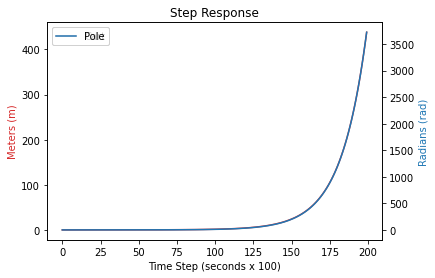

[2] loss: 9593887.000
[3] loss: 6240866.500
[4] loss: 4343904.000
[5] loss: 3106720.250
[6] loss: 2199448.250


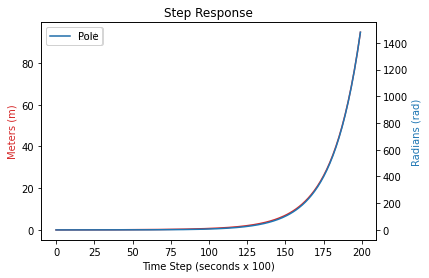

[7] loss: 1527610.500
[8] loss: 1068054.000
[9] loss: 756440.938
[10] loss: 533841.812
[11] loss: 372174.906


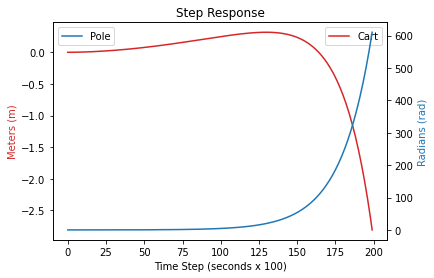

[12] loss: 255882.953
[13] loss: 167568.578
[14] loss: 105530.016
[15] loss: 65754.531
[16] loss: 38998.918


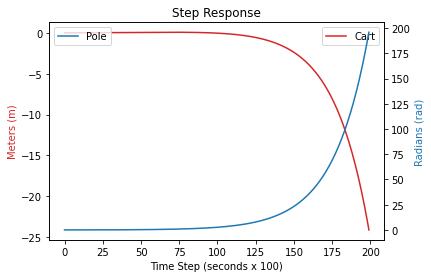

[17] loss: 23450.033
[18] loss: 14262.174
[19] loss: 8425.721
[20] loss: 5010.345
[21] loss: 3131.453


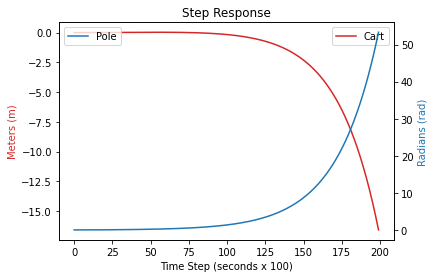

[22] loss: 1990.738
[23] loss: 1231.654
[24] loss: 777.977
[25] loss: 461.950
[26] loss: 308.232


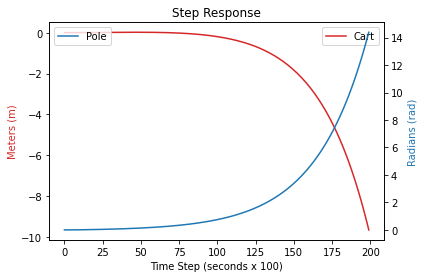

[27] loss: 216.870
[28] loss: 151.714
[29] loss: 105.456
[30] loss: 69.025
[31] loss: 43.562


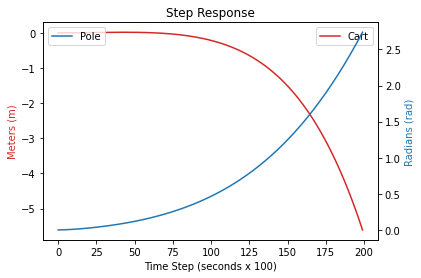

[32] loss: 28.633
[33] loss: 20.658
[34] loss: 15.256
[35] loss: 10.254
[36] loss: 6.738


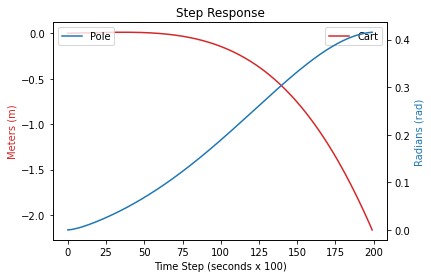

[37] loss: 4.657
[38] loss: 3.383
[39] loss: 2.280
[40] loss: 0.975
[41] loss: 0.271


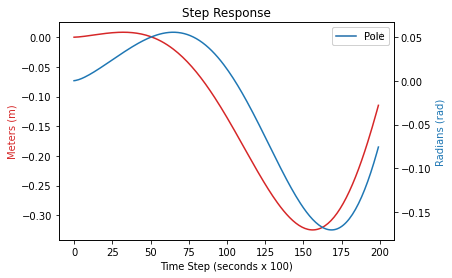

[42] loss: 0.121
[43] loss: 0.077
[44] loss: 0.059
[45] loss: 0.046
[46] loss: 0.033


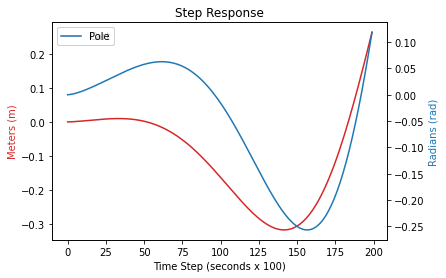

[47] loss: 0.015
[48] loss: 0.004
[49] loss: 0.002
[50] loss: 0.001
[51] loss: 0.000


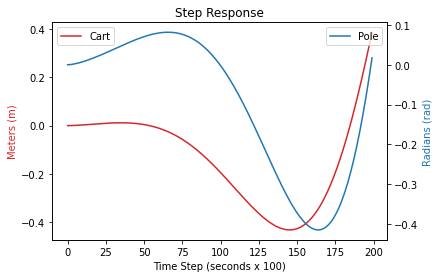

[52] loss: 0.000
[53] loss: 0.000
[54] loss: 0.000
[55] loss: 0.000
[56] loss: 0.000


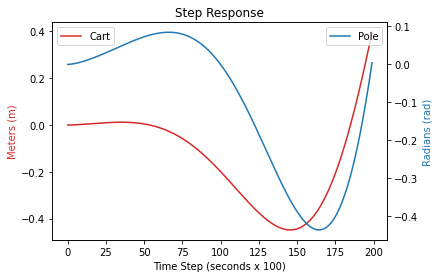

[57] loss: 0.000
[58] loss: 0.000
[59] loss: 0.000
[60] loss: 0.000
[61] loss: 0.000


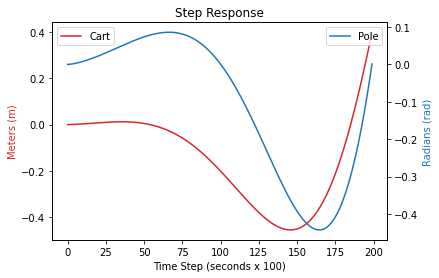

[62] loss: 0.000
[63] loss: 0.000
[64] loss: 0.000
[65] loss: 0.000
[66] loss: 0.000


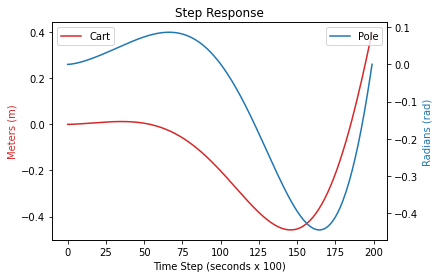

[67] loss: 0.000
[68] loss: 0.000
[69] loss: 0.000
[70] loss: 0.000
[71] loss: 0.000


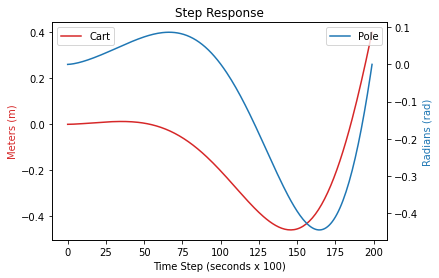

[72] loss: 0.000
[73] loss: 0.000
[74] loss: 0.000
[75] loss: 0.000
[76] loss: 0.000


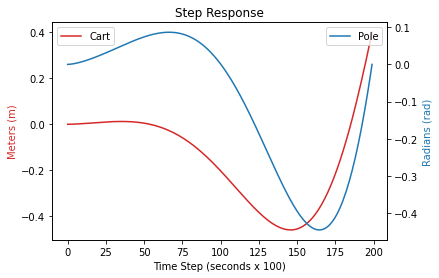

[77] loss: 0.000
[78] loss: 0.000
[79] loss: 0.000
[80] loss: 0.000
[81] loss: 0.000


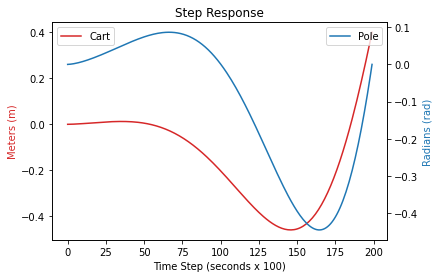

[82] loss: 0.000
[83] loss: 0.000
[84] loss: 0.000
[85] loss: 0.000
[86] loss: 0.000


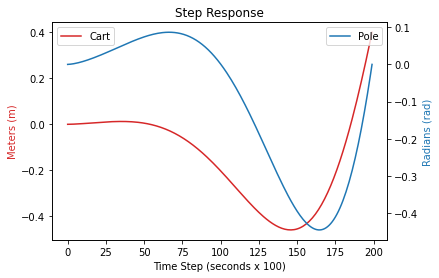

[87] loss: 0.000
[88] loss: 0.000
[89] loss: 0.000
[90] loss: 0.000
[91] loss: 0.000


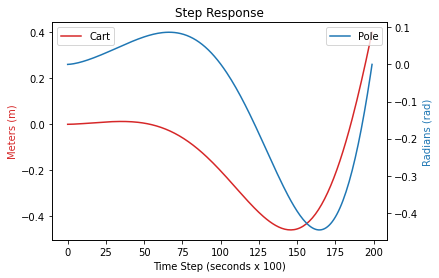

[92] loss: 0.000
[93] loss: 0.000
[94] loss: 0.000
[95] loss: 0.000
[96] loss: 0.000


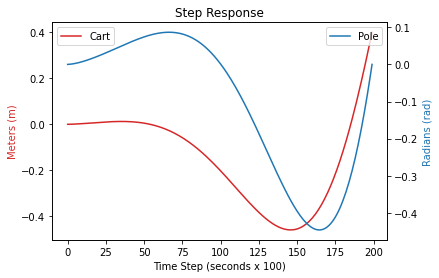

[97] loss: 0.000
[98] loss: 0.000
[99] loss: 0.000
[100] loss: 0.000


In [7]:
# Parameters for Running the System
dim_input = 4 # Number of Inputs to Neural Network = Number of States
dim_output = 4 # Number of Outputs from Neural Network = Number of Gains of K
dim_hidden = 10 # Hidden Layers for advanced computation of gains
ref = 0.4 #Reference Position for Cart
T = 200 #Time Steps to Simulate
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c,d, T,ref)  # define simulation
o = Optimize(s)  # define optimizer
error = o.train(100) # Store Error for Convergence Plot

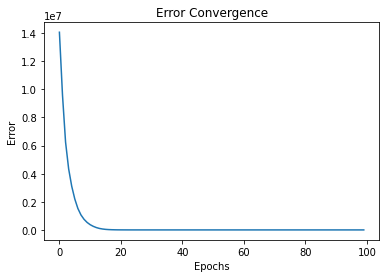

In [8]:
# Plotting Convergence
plt.plot(t.tensor(error).detach().numpy())
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error Convergence')
plt.show()

In [9]:
# Ideal Controller Gains
print('The ideal Controller K = ',s.action_trajectory[-1][:].clone().detach().numpy())

The ideal Controller K =  [-1.4476386 -3.9880772  0.8849648  4.138512 ]


# <h3> Analysis of Results
Using the Controller $K = \begin{bmatrix}
-1.4476386 & -3.9880772  &0.8849646  &4.138512
\end{bmatrix}$, we were able to bring the position of the cart to $r =0.4$ meters while the pole was kept upright at $0$ degrees.
<br/> The state trajectory of the system with the optimized controller can be visualized below:<br/>

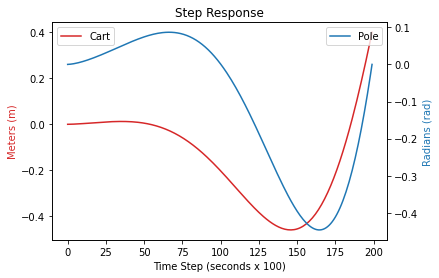

In [10]:
o.visualize()

This shows that the controller was able to stabilize the system in 2 seconds.<br/>
Thus it can be claimed that one can find an ideal controller $K$ for a dynamic system that optimizes the
required step response.<br/>
Future improvement could include extending this approach to:<br/>
1. Stabilizing both pole and cart position to a certain reference.<br/>
2. Stabilizing a dual pole system on the same cart.